# TL;DR

Compare a MLP and a CNN.

Highly inspired from the very good deep learning course at NYU.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# function to count number of parameters of a NN
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("I am running on {}".format(device))

I am running on cuda:0


# Load the Dataset (MNIST)


We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# Take the dataset, fetch it, install it in the directory, and unfold the directory, and associate each image to a label
# Creates a class
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # Dataset is really well known, std and mean are hardcoded 
                       # with our own dataset, we'd have to do it ourself. 
                   ])),
    batch_size=64, shuffle=True) # batch size is random number that was chosen 

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(), # transform into a tensor
                       transforms.Normalize((0.1307,), (0.3081,)) # normalize it 
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



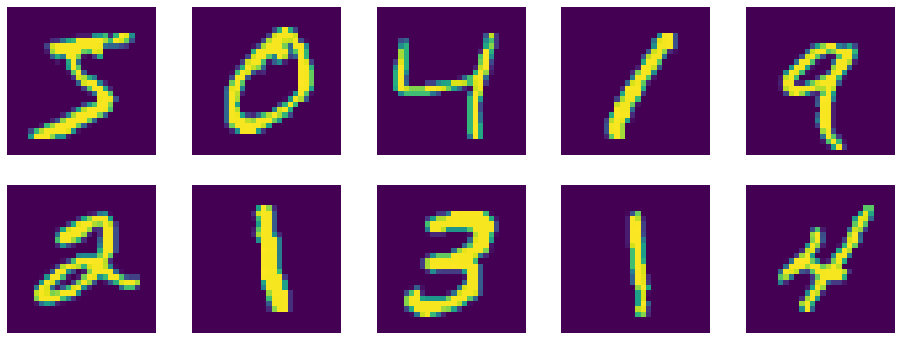

In [4]:
# show some MNIST images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

# Create the model classes
A Multi-Layer Perceptron and a simple Convolutional Neural Network (LeNet architecture from the original paper).

In [5]:
class MLP(nn.Module): # inherets all the predefined functions that nn has 
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__() # what is super? 
        self.input_size = input_size
        self.network = nn.Sequential( #sequential layers
            # First layer, linear 
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size),
            # gives probability for each number as an output 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

class LeNet(nn.Module):
    # main thing changed: convol. layer instead of linear 
    def __init__(self, input_size, n_feature, output_size):
        super(LeNet, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        # order not defined, until the forward function is introduced and then that defines the order 
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # flatten 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Training functions.


In [6]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    # model will have a vector corresponding to weights and bias'
    model.to(device) # send to the device, usually in this device
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # take my NN and get the best weights, given the images and labels
    print('Number of parameters: {}'.format(get_n_params(mlp)))

    model.train() # nn module has a .train part to it 
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad() # set the gradient of the optimizer
        output = model(data)
        loss = F.nll_loss(output, target) # apply the loss function to it 
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected network

In [7]:
n_hidden = 8 # number of hidden units

# how does it know it's 784? where was it defined?

mlp = MLP(input_size, n_hidden, output_size)

# in dataset, have 60,000 examples. Take a bunch of batches with 6400 samples. At each batch, calculate loss. 
for epoch in range(0, 1):
    train(epoch, mlp) # train 
    test(mlp) # test with the test set we've reserved

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.369610
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.541582
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.738328
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.900945
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.639610
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.550186
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.701298
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.523726
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.195105
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.571511

Test set: Average loss: 0.4299, Accuracy: 8790/10000 (88%)



In [8]:
def view_classify(img, score):
    score = score.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), score)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['0',
                        '1',
                        '2',
                        '3',
                        '4',
                        '5',
                        '6',
                        '7',
                        '8',
                        '9'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

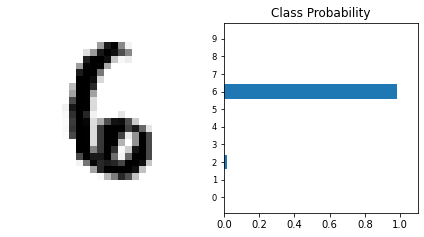

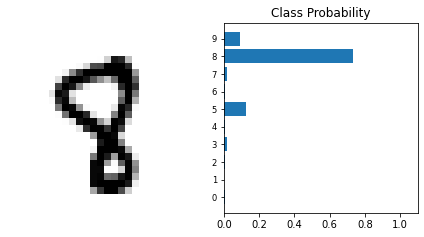

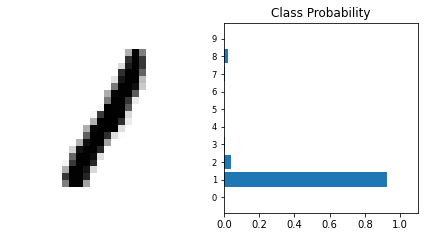

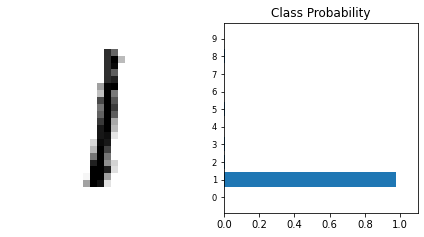

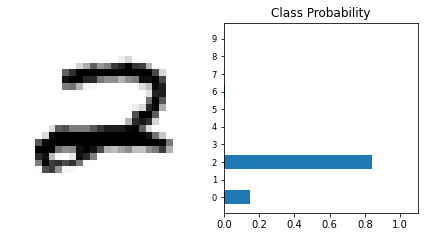

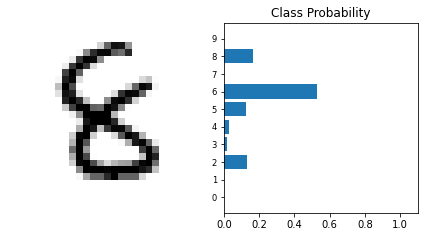

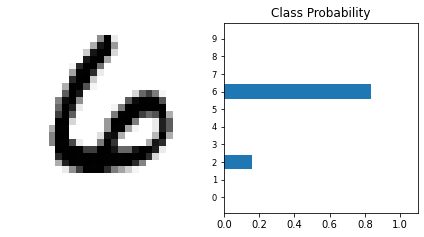

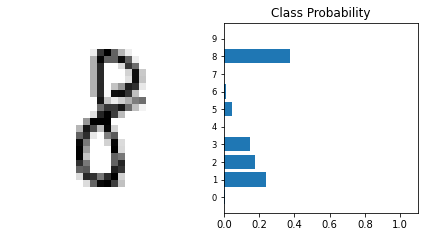

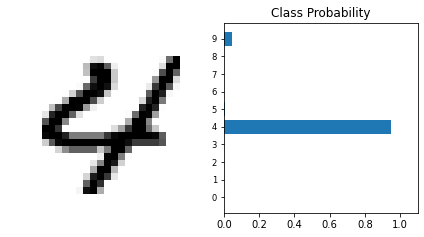

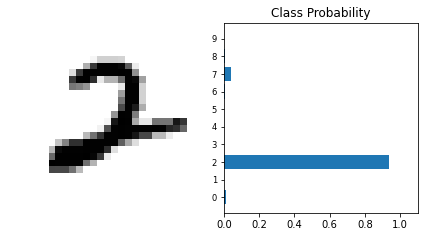

In [9]:
dataiter = iter(test_loader)
mlp.eval()
import numpy as np
for _ in range(10):
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    img = images[0]

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logscores = mlp(img)
    # Output of the network are log-probabilities, need to take exponential for probabilities
    scores = torch.exp(logscores)

    # Plot the image and probabilities
    view_classify(img.cpu().resize_(1, 28, 28), scores.cpu())

# Train a ConvNet with the same number of parameters

In [10]:
# Training settings 
n_features = 6 # number of feature maps

cnn = LeNet(input_size, n_features, output_size)

for epoch in range(0, 1):
    train(epoch, cnn)
    test(cnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331594
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.162999
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.674669
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.329655
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.231125
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.164538
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.269906
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.189782
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.251660
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.187764

Test set: Average loss: 0.1478, Accuracy: 9576/10000 (96%)



# Remark

_The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images_

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

### What happens if the assumptions are no longer true?

Let's permute the pixels: destroying locality information

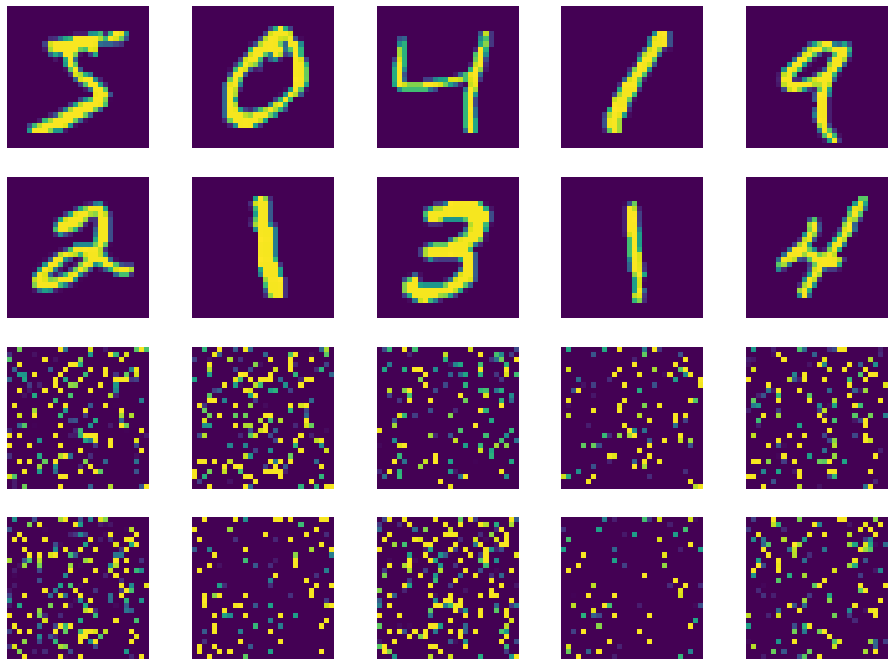

In [11]:
perm = torch.randperm(784)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

# ConvNet with permuted pixels

In [12]:
# Training settings 
n_features = 6 # number of feature maps

cnn = LeNet(input_size, n_features, output_size)

for epoch in range(0, 1):
    train(epoch, cnn, perm)
    test(cnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301777
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.250257
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.121509
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.803770
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.308842
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.210089
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.904088
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.713045
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.562457
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.436554

Test set: Average loss: 0.6130, Accuracy: 8008/10000 (80%)



# Fully-Connected  MLP with Permuted Pixels

In [13]:
# same as before...
#mlp = MLP(input_size, n_hidden, output_size)

for epoch in range(0, 1):
    train(epoch, mlp, perm)
    test(mlp, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.458611
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.468534
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.656695
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.705530
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.286273
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.321368
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.291639
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.473334
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.565831
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.250552

Test set: Average loss: 0.3376, Accuracy: 9018/10000 (90%)



# Remark

The CNN performance drops when we permute the pixels, but the MLP fully connected performance stays the same

* CNN makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [14]:
accuracy_list

[87.9, 95.76, 80.08, 90.18]

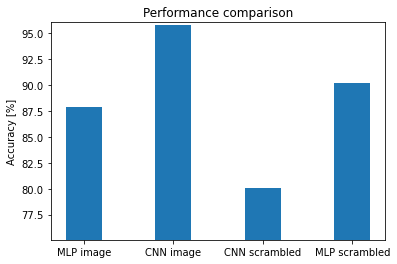

In [15]:
plt.bar(('MLP image', 'CNN image',
         'CNN scrambled', 'MLP scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

### Checking Model Parameters

In [16]:
print(cnn)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [17]:
print(mlp)

MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


# Some conclusions:

### Prior knowledge

To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

### Deep Learning
What happens in Deep Learning:

* Many layers: compositionality
* Convolutions: locality + stationarity of images  - shared weights
* Pooling: Invariance of object class to translations